In [1]:
import random
from datetime import datetime

import joblib
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf

In [2]:
BATCH_SIZE = 64
RANDOM_SEED = 0
IMG_SIZE = (160, 160)
IMG_SHAPE = (160, 160, 3)
EPOCHS = 20
LEARNING_RATE = 0.0001

STARTED_TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
# load model
class_names = joblib.load("../model/class_names-20220326-151658.z")

model = tf.keras.models.load_model("../model/mobilenet-20220326-151658.h5")
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

2022-04-08 22:52:42.510957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-08 22:52:42.519439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-08 22:52:42.519961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-08 22:52:42.520521: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

In [7]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    convLayer = model.get_layer(last_conv_layer_name).output
    grad_model = tf.keras.models.Model(
        [model.inputs], [convLayer, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_logits, prediction_logits = grad_model(img_array)
        pred_index = tf.argmax(prediction_logits[0])
        loss_value = prediction_logits[:, pred_index]

        grads = tape.gradient(loss_value, last_conv_layer_logits)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        heatmap = tf.matmul(last_conv_layer_logits[0], pooled_grads[..., tf.newaxis])
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

        return heatmap.numpy()

In [8]:
def create_heatmap(heatmap, image_size):
  # Use RGB values of the colormap
  nipy_cm = plt.cm.get_cmap("nipy_spectral")
  nipy_colors = nipy_cm(np.arange(256))[:, :3]
  heatmap_cm = nipy_colors[heatmap] * 255

  # Create an image with RGB colorized heatmap
  return resize(heatmap_cm, image_size, anti_aliasing=True)

In [9]:
def create_superimposed_heatmap(original_img, heatmap, alpha=0.4):
  return heatmap * alpha + original_img

In [10]:
def create_superimposed_mask(original_img, heatmap):
  # Median/Mean thresholding
  threshold_level = np.median(heatmap)
  heatmap_mask = heatmap[:, :, 0] < threshold_level

  heatmap_mask = heatmap_mask.astype(int)
  heatmap_mask[heatmap_mask == 1] = 255.0

  base_img = original_img.astype(int)
  return np.bitwise_or(heatmap_mask[:, :, np.newaxis], base_img)

In [11]:
img_path = '../dataset/train/Bacterialblight/BACTERAILBLIGHT3_006.jpg'
img_path = '../dataset/w.jpeg'

pred_img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
pred_img = tf.keras.preprocessing.image.img_to_array(pred_img)
pred_img = preprocess_input(pred_img)
pred_img = np.expand_dims(pred_img, axis=0)

# predict
predicted = tf.nn.softmax(model.predict(pred_img))
predicted = tf.argmax(predicted, axis=1)

# Rescale heatmap to a range 0-255
heatmap_array = gradcam_heatmap(pred_img, model, "Conv_1")
heatmap_array = np.uint8(255 * heatmap_array)

# Load original image
original_image = tf.keras.preprocessing.image.load_img(img_path)
original_image = tf.keras.preprocessing.image.img_to_array(original_image)

2022-04-08 22:52:51.475397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-08 22:52:53.487169: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-04-08 22:52:55.236850: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-08 22:52:55.293842: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-08 22:52:55.293943: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-04-08 22:52:55.350192: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-08 22:52:55.350374: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

In [12]:
# Create heatmap
image_size = (original_image.shape[0], original_image.shape[1])
heatmap_arr = create_heatmap(heatmap_array, image_size)
heatmap_img = tf.keras.preprocessing.image.array_to_img(heatmap_arr)

# Grayed heatmap
heatmap_grayed_arr = rgb2gray(heatmap_arr)[:, :, np.newaxis]

# Superimpose the heatmap on original image
heatmap_imposed_arr = create_superimposed_heatmap(original_image, heatmap_arr, alpha=1.0)
heatmap_imposed_img = tf.keras.preprocessing.image.array_to_img(heatmap_imposed_arr)

# Threshold original image
masked_arr = create_superimposed_mask(original_image, heatmap_arr)
masked_img = tf.keras.preprocessing.image.array_to_img(masked_arr)

print("Original image", original_image.shape)
print("Heatmap", heatmap_arr.shape)

Original image (900, 1600, 3)
Heatmap (900, 1600, 3)


Text(0.5, 0, 'Predicted: Bacterialblight')

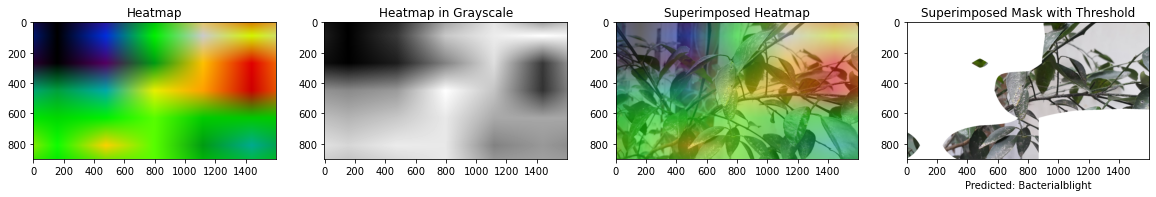

In [13]:
# Save the superimposed image
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
ax1.imshow(heatmap_img)
ax1.set_title("Heatmap")

ax2.imshow(heatmap_grayed_arr, cmap="gray")
ax2.set_title("Heatmap in Grayscale")

ax3.imshow(heatmap_imposed_img)
ax3.set_title("Superimposed Heatmap")

ax4.imshow(masked_img)
ax4.set_title("Superimposed Mask with Threshold")
ax4.set_xlabel("Predicted: {}".format(class_names[predicted[0]]))